# **Exercise 3**
## **Group members**:
* Antonio Feltrin, antonio.feltrin@studenti.unipd.it, ID 2097126
* Giosuè Sardo Infirri, giosue.sardoinfirri@studenti.unipd.it, ID 2090564 
* Riccardo Tancredi, riccardo.tancredi@studenti.unipd.it, ID 2089395
* Simone Toso, simone.toso.2@studenti.unipd.it, ID 2095484

#### **Import all necessary dependencies**

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 15

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## **Data and labels**
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [3]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

569.5269005085432
mean minimum distance between points:  23.321029500210262


# 1.
## t-SNE visualization

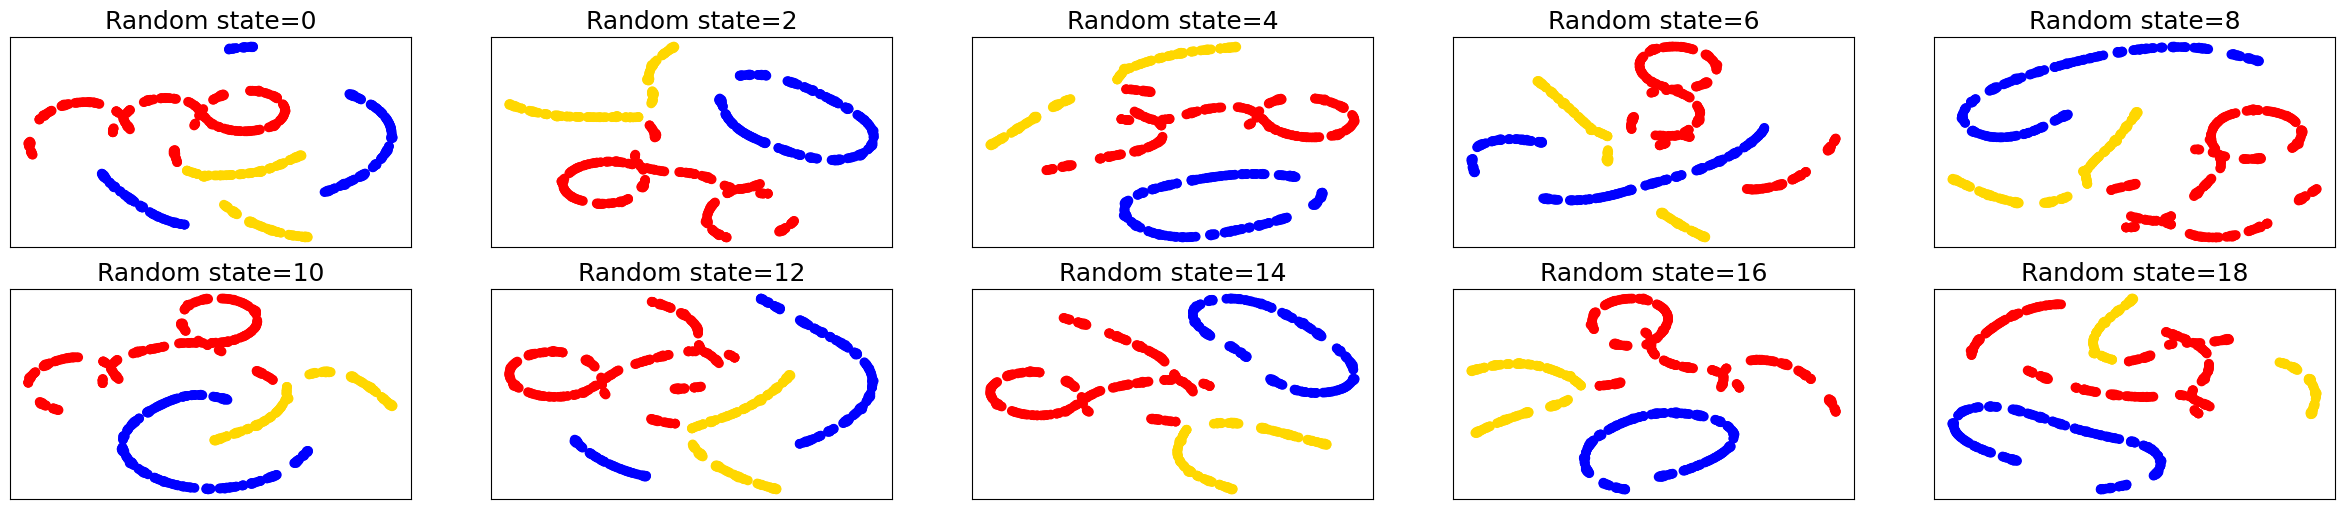

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
random_states = list(range(0, 20, 2))
# perplexities = [5, 10, 20, 40, 80]
perplexity = 10
Np = len(random_states)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(2,int(np.floor(Np/2)), figsize=(3*Np, 6))

X_all = [None]
for j in range(2):
    for i in range(int(len(random_states)/2)):
        ax = subplots[j, i]

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                            random_state=random_states[i+j*int(Np/2)], perplexity=perplexity)
        Y = tsne.fit_transform(data)
        t1 = time()
        ax.set_title("Random state=%d" % random_states[i+j*int(Np/2)])
        ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all.append(Y)
    
plt.show()

### We varied many times the *random_state* variable: the results, by comparing them with each other, depend on the chosen seed, but we see some recurrent structure among the data, with a fixed perplexity of $10$. It seems that the chosen perplexity is always able to properly seperate the data into 3 different clusters.

# 2.
## **DBSCAN**

In [5]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from collections import OrderedDict
ms = 6
res = []

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps_range = np.arange(1, 300) # [r,3*r,6*r,9*r,12*r]
min_sample_range = np.arange(1, 50)

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        res.append(nmi)
XX, YY = np.meshgrid(min_sample_range, eps_range)
res = np.array(res).reshape(YY.shape)

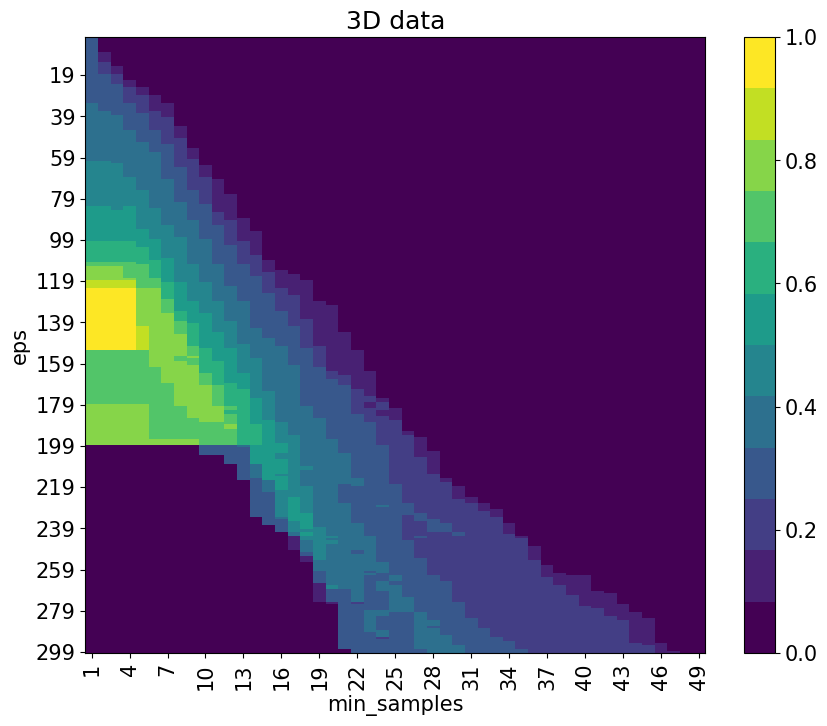

In [6]:
viridis = cm.get_cmap('viridis', 12)
fig, ax = plt.subplots(figsize=(10, 8))
psm = ax.pcolormesh(min_sample_range, eps_range, res[::-1], cmap=viridis, vmin=0., vmax=1.)
ax.set_title("3D data")
ax.set_xticks(np.arange(1, 50, 3))
ax.set_xticklabels(np.arange(1, 50, 3), rotation=90)
ax.set_yticks(eps_range[::20])
ax.set_yticklabels(eps_range[::-20])
ax.set_xlabel("min_samples")
ax.set_ylabel("eps")
fig.colorbar(psm, ax=ax)
plt.show()

### We see that there is a NMI peak around *eps* ~ 130 and very low *min_samples*. We know that the less *min_samples* we have the more clusters we get, so when *eps* is very large and *min_samples* is small, all data are clustered in the same group: this explains the dark box at the bottom left corner. For the opposite reason, it is clear that when *eps* is small all data can't be clustered, which explains the low NMI index. There is also a *transient diagonal zone* where we get higher and higher NMI where the right compromise between number of clusters and their radius is maximized. Therefore, it exists a correlation between these two parameters. We suppose this correlation to be linear, due to the fact that we know that data are curves in 3D space. So, a sphere of increasing radius *eps* contains a number of points that grows linearly.